## 4.2最新版训练Unet全流程
    包含 random随机种子存储，大图预处理(包含旋转，缩放，色彩对比度范围随机变化，图像填充裁切)，patch分割，训练，存储model，测试model。

### 加载基本库

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import gc

# 封装的函数模块，model部分全部引用
from functions.data import prepare_dataset,get_optimized_loaders
from functions.model import *
from functions.data import SegmentationDataset
from functions.imagePreprocessing import ImagePreprocessor


### 数据集准备

In [3]:
# train_data, test_data = prepare_dataset("Kasthuri++")
train_data, test_data = prepare_dataset("Lucchi++")

# 第一次运行时：预处理并保存
train_dataset = SegmentationDataset(
    data_list=train_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)

test_dataset = SegmentationDataset(
    data_list=test_data,
    patch_size=256,
    stride=128,
    preProcess=True,  # 启用预处理

)

train_loader, test_loader = get_optimized_loaders(
    train_dataset, 
    test_dataset, 
    batch_size=32,  # 增加批大小
    num_workers=4
)



Train Data (Lucchi++): [{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png', 'index': 0}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png', 'index': 1}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png', 'index': 2}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png', 'index': 3}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png', 'index': 4}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png', 'index': 5}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png', 'index': 6}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png', 'index': 7}, {'image'

处理图像: 100%|██████████| 165/165 [00:19<00:00,  8.46it/s]


数据集预处理完成，共生成 5627 个patch
开始数据集预处理...


处理图像: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]

数据集预处理完成，共生成 5941 个patch


### 训练Unet模型阶段

In [4]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(num_classes=1).to(device)

cuda


#### 开始训练

In [7]:
optimized_train_model(model, train_loader, test_loader, num_epochs=50, device=device)


KeyboardInterrupt: 

#### 可选保存模型

In [ ]:
# Save model
torch.save(model.state_dict(), "models/UnetTrain/overlaping_unet_segmentation_try4.2V0A1K.pth")

### 测试model性能

处理图像: mask1049
使用设备: cuda
模型路径: models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth
模型已从 models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth 加载
原始图像尺寸: 1553x1334
预处理后图像尺寸: 1792x1536
填充信息: 上=119, 下=120, 左=101, 右=101
评估指标: IoU=0.4027, Dice=0.5742
原始预测指标: IoU=0.4027, Dice=0.5742
后处理后指标: IoU=0.4113, Dice=0.5829
指标改善: IoU: 2.13%, Dice: 1.51%
最终评估指标: IoU=0.4113, Dice=0.5829


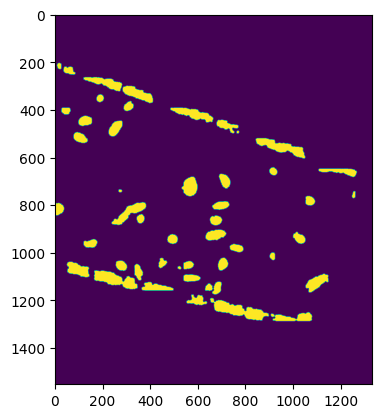

In [8]:
## 4.2最新的predict全流程设置
# 设置参数
model_path = "models/UnetTrain/overlaping_unet_segmentation_try4.2.2L_random_iou.pth"  # 模型路径

# image_path = "dataset/Lucchi++/Test_In/mask0055.png"  # 测试图片路径
# mask_path = "dataset/Lucchi++/Test_Out/55.png"  # 真实掩码路径（如果有）

image_path = "dataset/Kasthuri++/Test_In/mask1049.png"  
mask_path = "dataset/Kasthuri++/Test_Out/mask1049.png"  


# image_path = "dataset/VNC/Test_In/16.tif"  
# mask_path = "dataset/VNC/Test_Out/16.png"  

save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小
stride = 128  # 步长

# 执行分割流程
pred_mask, metrics = segmentation_pipeline(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,
    value=-30,
    alpha=1.0
)

if metrics:
    print(f"最终评估指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")
    
plt.imshow(pred_mask)
plt.show()